In [2]:
# Import libraries
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Full dataset
hourly_aq = pd.read_csv('../../aqi.csv')

## Feature generation

In [4]:
# Pivot the parameters to be useful for feature work
hourly_feat = hourly_aq.pivot(index=['datetime_est', 'site'], columns='parameter', values='report_value').reset_index()

# We want multiple features from the date. Let's create a bunch
hourly_feat['datetime_est'] = pd.to_datetime(hourly_feat['datetime_est'])
hourly_feat['year'] = hourly_feat['datetime_est'].dt.year
hourly_feat['month'] = hourly_feat['datetime_est'].dt.month
hourly_feat['day'] = hourly_feat['datetime_est'].dt.day
hourly_feat['date'] = hourly_feat['datetime_est'].dt.date
hourly_feat['month_day'] = hourly_feat['datetime_est'].dt.strftime('%m-%d')
hourly_feat['hour'] = hourly_feat['datetime_est'].dt.hour
hourly_feat['weekday'] = hourly_feat['datetime_est'].dt.day_name()
hourly_feat['weekday_num'] = hourly_feat['datetime_est'].dt.weekday
hourly_feat['is_weekend'] = hourly_feat['weekday_num'].apply(lambda x: 1 if x >= 5 else 0)
hourly_feat['week_of_year'] = hourly_feat['datetime_est'].dt.isocalendar().week
hourly_feat['quarter'] = hourly_feat['datetime_est'].dt.quarter

def time_of_day(hour):
    if 0 <= hour < 6:
        return 'Night'
    elif 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Afternoon'
    elif 18 <= hour < 24:
        return 'Evening'
hourly_feat['time_of_day'] = hourly_feat['hour'].apply(time_of_day)

def get_season(date):
    month = date.month
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'
hourly_feat['season'] = hourly_feat['datetime_est'].apply(get_season)

hourly_feat.columns

Index(['datetime_est', 'site', '4-12-01T23:00:00"', '6.2', 'AMBTEMP',
       'AREF_500', 'AZERO200', 'BAMRAW', 'BCSTAT', 'BLACK CARBON',
       ...
       'date', 'month_day', 'hour', 'weekday', 'weekday_num', 'is_weekend',
       'week_of_year', 'quarter', 'time_of_day', 'season'],
      dtype='object', name='parameter', length=142)

In [5]:
# Different stations use slightly different features for similar concepts. We
# would prefer to combine from a neighboring stations rather than impute.
meteorology_cols = [
    #'datetime_est', 'site',
    # Temp
    'OUT_T',
    # Wind
    'RWS', 'SONICWS', 'WNSP', 'Peak Wind Gust', 'SIGTHETA',
    # Wind dir
    'RWD', 'SONICWD', 'WNDR',
    # Other
    'BP', 'OUT_RH']

#meteorology = hourly_feat[meteorology_cols]

# Create indicator for missing values we are about to fill
#for col in meteorology_cols:
#    hourly_feat[f'{col}_filled'] = hourly_feat[col].isna().astype(int)

# Fillna from the average of other stations with values
hourly_feat[meteorology_cols] = hourly_feat.groupby(
    ['datetime_est'])[meteorology_cols].transform(
    lambda x: x.fillna(x.mean()))
#  Try faster method
#import swifter
#hourly_feat[meteorology_cols] = hourly_feat.groupby(
#    ['site', 'datetime_est'])[meteorology_cols].apply(
#    lambda x: x.swifter.apply(lambda y: y.fillna(y.mean())))

# Feature gen: convert wind direction from degrees to categorical direction
def wind_dir(degs):
    if 45 <= degs < 135:
        return 'E'
    elif 135 <= degs < 225:
        return 'S'
    elif 225 <= degs < 315:
        return 'W'
    elif 315 <= degs <= 360:
        return 'N'
    elif degs < 45:
        return 'N'
hourly_feat['wind_dir'] = hourly_feat['SONICWD'].apply(wind_dir)

In [5]:
hourly_feat.shape

(1053447, 143)

Outcome selection and test split

In [6]:
from sklearn.model_selection import train_test_split

# Proportion of NA in the result for each feature
hourly_feat.isna().mean()

# Define the outcome for this model
outcome = 'PM25_coalesced' #'SO2', 'H2S', 'H2S_SO2', 'PM25', 'NO2'

# Prep for dropping rows, copying over so we don't have to rerun feature gen
hourly_feat2 = hourly_feat.copy()

# Coalesce the PN25 label from the various types of detectors
pm25_labels = ['PM25', 'PM25B', 'PM25T', 'PM25_640']
hourly_feat2['PM25_coalesced'] = hourly_feat2[pm25_labels].bfill(axis=1).iloc[:, 0]
# which column did we use to source the coalesced?
hourly_feat2['PM25_source'] = hourly_feat2[pm25_labels].apply(lambda row: row.first_valid_index(), axis=1)

# We also calculate a 'meet standard' label for the PM2.5 level
who_guideline = 15
#hourly_feat2['met_who_standard'] = hourly_feat2['PM25_coalesced'] < who_guideline
# need to calculate daily rates
daily_avg = hourly_feat2.dropna(subset=['PM25_coalesced']).groupby([hourly_feat2['datetime_est'].dt.date, 'site']
)['PM25_coalesced'].transform('mean')
hourly_feat2['met_who_standard'] = daily_avg < who_guideline

# Drop NAs rows from outcome, since we don't want to impute outcomes
hourly_feat2.dropna(subset=[outcome], inplace=True)

# We have a single observeation from Liberty, which is erroneous
hourly_feat2.drop(hourly_feat2[hourly_feat2['site'] == 'Liberty'].index, inplace=True)
# And 'Lawrenceville 2' is a mislabeling of Lawrenceville
hourly_feat2['site'] = hourly_feat2['site'].replace('Lawrenceville 2', 'Lawrenceville')

# Now that we've removed uninteresting rows, remove the columns that only applied to those
hourly_feat2.dropna(axis=1, how='all', inplace=True)

# Different features are available based on the monitoring station
so2_feats = ['site', 'OUT_T', 'BP', 'OUT_RH',
             'SIGTHETA', 'SONICWD', 'SONICWS', 'wind_dir', 'year', 'month', 'day',
              'hour', 'weekday', 'weekday_num', 'is_weekend',
              'week_of_year', 'quarter', 'time_of_day', 'season']
pm25_feats = ['site', 'PM25_source', 'OUT_T', 'BP', 'OUT_RH',
             'SIGTHETA',  'SONICWS', 'RWS', 'WNSP', 'Peak Wind Gust', 
             'SONICWD', 'WNDR', 'wind_dir', 'year', 'month', 'day',
              'hour', 'weekday', 'weekday_num', 'is_weekend',
              'week_of_year', 'quarter', 'time_of_day', 'season']

# Drop rows with NAs in columns we will use
#hourly_feat2 = hourly_feat2[so2_feats, outcome]
# We have one observation from Fayette that is missing too much and causes problems
# Note: need to check this only drops 1 row (or is even necessary) when using different datasets
hourly_feat2 = hourly_feat2.dropna(subset=['SONICWD'])

# Select features and label for model
X = hourly_feat2[pm25_feats]
y = hourly_feat2[outcome]
y_bin = hourly_feat2['met_who_standard'].astype(int)

# How much NA in rows do we have left after subsetting to features? These will be imputed
null_in_rows = X[X.isnull().any(axis=1)]
print(null_in_rows.shape)

# Split out test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=100)
X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(X, y_bin, random_state=100)

# Split out temporal test set
# Need to determine cutoff for 80/20 split, since we can have varying number of observations by time period
cutoff = hourly_feat2['datetime_est'].min() + (hourly_feat2['datetime_est'].max() - hourly_feat2['datetime_est'].min()) * 0.8
print(f'Temporal training cutoff: {cutoff}')

X_train_time, X_test_time = X[hourly_feat2['datetime_est'] < cutoff], X[hourly_feat2['datetime_est'] >= cutoff]
y_train_time, y_test_time = y[hourly_feat2['datetime_est'] < cutoff], y[hourly_feat2['datetime_est'] >= cutoff]
y_train_bin_time, y_test_bin_time = y_bin[hourly_feat2['datetime_est'] < cutoff], y_bin[hourly_feat2['datetime_est'] >= cutoff]


(307585, 24)
Temporal training cutoff: 2023-06-05 06:24:00


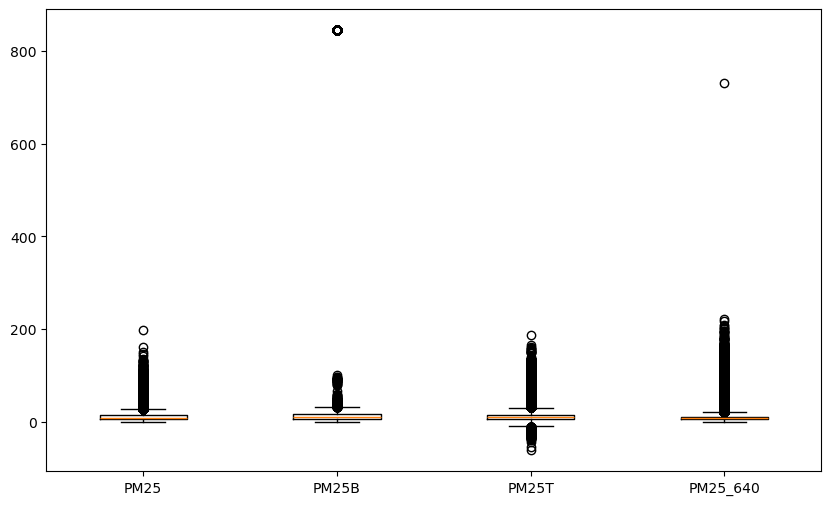

parameter         PM25         PM25B          PM25T       PM25_640
count      69901.00000  52020.000000  193717.000000  151398.000000
mean          11.64527     70.109708      11.826138       8.964480
std           12.06972    214.959117      10.552751       8.550374
min           -2.00000     -2.000000     -62.000000       0.000000
25%            5.00000      6.000000       5.000000       4.700000
50%            8.00000     10.000000       9.000000       7.100000
75%           14.00000     16.000000      15.000000      10.900000
max          197.00000    845.000000     186.000000     731.200000
PM25_coalesced
True              334265
False              79979
Name: count, dtype: int64
PM25_coalesced
True              0.806928
False             0.193072
Name: proportion, dtype: float64


In [6]:
# Simple plots of descriptives of our labels and how they were coalesced

fig, ax = plt.subplots(figsize=(10, 6))
ax.boxplot([hourly_feat2[label].dropna() for label in pm25_labels], tick_labels=pm25_labels)
plt.show()

print(hourly_feat2[pm25_labels].describe(percentiles=[0.25, 0.75]))

pd.crosstab(hourly_feat2['PM25_source'], hourly_feat2['met_who_standard'])
pd.crosstab(hourly_feat2['PM25_source'], hourly_feat2['met_who_standard'], normalize='index')
hourly_feat2['met_who_standard'].value_counts()
hourly_feat2['met_who_standard'].value_counts(normalize=True)

print(pd.DataFrame(daily_avg < who_guideline).value_counts())
print(pd.DataFrame(daily_avg < who_guideline).value_counts(normalize=True))


In [43]:
pd.crosstab(hourly_feat2['year'], hourly_feat2['PM25_source'])
pd.crosstab(hourly_feat2['site'], hourly_feat2['PM25_source'])

PM25_source,PM25,PM25B,PM25T,PM25_640
site,,,,
Avalon,0,10630,54370,15154
Clairton,0,0,0,26546
Lawrenceville,19,41371,903,0
Liberty 2,27278,0,47674,4507
Lincoln,42604,0,0,0
North Braddock,0,0,0,27298
Parkway East,0,0,70927,8895
Pittsburgh,0,0,0,36067


## ML model selection

In [7]:
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.pipeline import make_pipeline

imp = SimpleImputer()
#imp_iter = IterativeImputer()
ohe = OneHotEncoder()
mms = MinMaxScaler()

ct = make_column_transformer(
       (imp, ['OUT_T', 'SIGTHETA', 'SONICWD', 'SONICWS', 'BP',
              'OUT_RH', 'RWS', 'WNSP', 'WNDR', 'Peak Wind Gust']),
       (ohe, ['site', 'time_of_day', 'season', 'weekday', 'wind_dir', 'PM25_source']),
       remainder = 'passthrough'
)

ct_scale = make_column_transformer(
       (imp, ['SIGTHETA', 'SONICWD', 'SONICWS', 'BP',
              'OUT_RH', 'RWS', 'WNSP', 'WNDR', 'Peak Wind Gust']),
       (ohe, ['site', 'time_of_day', 'season', 'weekday', 'wind_dir', 'PM25_source']),
       (make_pipeline(imp, mms), ['OUT_T']),
       remainder = 'passthrough'
)

### Regression models on particulate level

In [8]:
from sklearn.pipeline import make_pipeline

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import AdaBoostRegressor, HistGradientBoostingRegressor #RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import make_scorer, root_mean_squared_error, mean_absolute_error, r2_score

pipelines = {
    "Linear Regression": make_pipeline(ct, LinearRegression()),
    #"Ridge Regression": make_pipeline(ct, Ridge()),
    "Lasso Regression": make_pipeline(ct, Lasso()),
    #"Random Forest": make_pipeline(ct, RandomForestRegressor(max_depth=10)),
    "KNN": make_pipeline(ct, KNeighborsRegressor()),
    "XGBoost": make_pipeline(ct, XGBRegressor()),
    "XGBoost Tuned": make_pipeline(ct, XGBRegressor(max_depth=6, learning_rate=.1)),
    "AdaBoost": make_pipeline(ct, AdaBoostRegressor()),
    "GradientBoost": make_pipeline(ct, HistGradientBoostingRegressor()),
    #"SVR": make_pipeline(ct, scaler, SVR())  # need to scale features for SVR
}

val_metrics = {
    "RMSE": make_scorer(root_mean_squared_error),
    "MAE": make_scorer(mean_absolute_error),
    "R-Squared": make_scorer(r2_score)
}

In [ ]:
# Evaluate pipelines using cross-validation
for name, pipeline in pipelines.items():
    print(f'{name}:')
    scores = cross_validate(pipeline, X, y, cv=5, scoring=val_metrics, return_train_score=False)
    for metric_name in val_metrics.keys():
        mean_score = scores[f'test_{metric_name}'].mean()
        print(f'{metric_name}: {mean_score:.4f}')
    
    print('')


Linear Regression:
RMSE: 127.3810
MAE: 68.8664
R-Squared: -242.6285

Lasso Regression:
RMSE: 67.7527
MAE: 31.7541
R-Squared: -15.3491

KNN:
RMSE: 67.2917
MAE: 18.8443
R-Squared: -14.7379

XGBoost:
RMSE: 42.9560
MAE: 13.2583
R-Squared: 0.0325

XGBoost Tuned:
RMSE: 42.5934
MAE: 12.9753
R-Squared: 0.1106

AdaBoost:
RMSE: 42.9488
MAE: 13.9311
R-Squared: 0.0106

GradientBoost:
RMSE: 42.7899
MAE: 13.0091
R-Squared: 0.0638



In [16]:
# Grid search for hyperparameters for XGBoost
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.pipeline import make_pipeline

# Parameters to search. XG's defaults are listed first
param_grid = {'xgbregressor__max_depth': [6, 3, 8],
              #'xgbregressor__n_estimators': [100, 300, 20],
              'xgbregressor__learning_rate': [.3, .1, .5],
              #'xgbregressor__subsample': [1, .5],
              #'xgbregressor__colsample_bytree': [1, .5],
              #'xgbregressor__min_child_weight': [1, 5]
}
# Separate grid for quantile objective, as it requires an alpha parameter
param_grid_quantile = {'xgbregressor__max_depth': [6, 3, 8],
              #'xgbregressor__n_estimators': [100, 300, 20],
              'xgbregressor__learning_rate': [.3, .1, .5],
              'xgbregressor__objective': ['reg:quantileerror'],
              'xgbregressor__quantile_alpha': [.5, .75]
              #'xgbregressor__subsample': [1, .5],
              #'xgbregressor__colsample_bytree': [1, .5]
}

#scale_pos_weight = sum(neg) / sum(pos)

xgb = make_pipeline(ct, XGBRegressor())

grid_reg = GridSearchCV(xgb, param_grid, cv=5, verbose=1,
                        scoring=['r2', 'neg_mean_absolute_error', 'neg_root_mean_squared_error'],
                        refit='neg_root_mean_squared_error')
#grid_quantile = GridSearchCV(xgb, param_grid_quantile, cv=5, verbose=1)
#RandomizedSearchCV

grid_reg.fit(X, y)
#grid_quantile.fit(X, y)

gs_params = ['mean_test_r2', 'mean_test_neg_mean_absolute_error', 'mean_test_neg_root_mean_squared_error', 'params']

print(pd.DataFrame(grid_reg.cv_results_).loc[:,gs_params])
#print(pd.DataFrame(grid_quantile.cv_results_).loc[:,gs_params])

print(grid_reg.best_score_)
#print(grid_quantile.best_score_)
print(grid_reg.best_params_)
#print(grid_quantile.best_params_)



Fitting 5 folds for each of 9 candidates, totalling 45 fits
   mean_test_r2  mean_test_neg_mean_absolute_error  \
0      0.032487                         -13.258255   
1     -0.227320                         -13.997528   
2      0.003884                         -13.352650   
3      0.110570                         -12.975265   
4     -0.237061                         -14.255868   
5      0.070955                         -12.995413   
6     -0.126517                         -13.609783   
7     -0.710961                         -14.603645   
8     -0.109358                         -13.792695   

   mean_test_neg_root_mean_squared_error  \
0                             -42.956037   
1                             -43.940358   
2                             -43.114335   
3                             -42.593433   
4                             -44.139404   
5                             -42.746749   
6                             -43.657443   
7                             -45.563711   
8  

In [45]:
# Validation metrics on test set

for name, pipeline in pipelines.items():
    print(f"{name} (Test set):")
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    for metric_name, scorer in val_metrics.items():
        test_score = scorer(pipeline, X_test, y_test)
        print(f"{metric_name}: {test_score:.4f}")
    
    print()
    

Linear Regression (Test set):
RMSE: 73.4531
MAE: 27.1813
R-Squared: 0.1500

Lasso Regression (Test set):
RMSE: 74.2720
MAE: 23.5176
R-Squared: 0.1309

KNN (Test set):
RMSE: 61.0203
MAE: 11.7026
R-Squared: 0.4134

XGBoost (Test set):
RMSE: 6.4533
MAE: 3.9289
R-Squared: 0.9934

AdaBoost (Test set):
RMSE: 19.1075
MAE: 7.7345
R-Squared: 0.9425

GradientBoost (Test set):
RMSE: 8.2750
MAE: 4.4612
R-Squared: 0.9892



In [46]:
# Validation on future time period test set

for name, pipeline in pipelines.items():
    print(f"{name} (Temporal test set):")
    pipeline.fit(X_train_time, y_train_time)
    y_pred = pipeline.predict(X_test_time)

    for metric_name, scorer in val_metrics.items():
        test_score = scorer(pipeline, X_test_time, y_test_time)
        print(f"{metric_name}: {test_score:.4f}")
    
    print()


Linear Regression (Temporal test set):
RMSE: 32.9437
MAE: 25.9651
R-Squared: -7.2907

Lasso Regression (Temporal test set):
RMSE: 31.6763
MAE: 25.2482
R-Squared: -6.6650

KNN (Temporal test set):
RMSE: 12.4616
MAE: 8.0306
R-Squared: -0.1863

XGBoost (Temporal test set):
RMSE: 11.7252
MAE: 7.1129
R-Squared: -0.0502

AdaBoost (Temporal test set):
RMSE: 11.6248
MAE: 7.3376
R-Squared: -0.0323

GradientBoost (Temporal test set):
RMSE: 11.9054
MAE: 6.9415
R-Squared: -0.0828



## Classifier models

In [9]:
# Define the pipeline for the classifier models

from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB, ComplementNB
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_validate
from sklearn.metrics import (make_scorer, root_mean_squared_error, mean_absolute_error, r2_score, cohen_kappa_score,
                             accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, log_loss)


# Classification on binary discretization of outcome
pipelines_bin = {
    "Logistic Regression": make_pipeline(ct, LogisticRegression(max_iter=1000)),
    #"Lasso Regression": make_pipeline(ct, Lasso()),
    "Naive Bayes": make_pipeline(ct, GaussianNB()),
    "Complement Naive Bayes": make_pipeline(ct_scale, ComplementNB()), # doesn't like negative temps
    "Random Forest": make_pipeline(ct, RandomForestClassifier(max_depth=25)),
    #"NN": make_pipeline(ct, MLPClassifier()),
    "XGBoost": make_pipeline(ct, XGBClassifier()),
    "XGBoost Tuned": make_pipeline(ct, XGBClassifier(learning_rate = .2, max_depth = 3, n_estimators = 40,
                                                     colsample_bytree = .5, scale_pos_weight = .8)),
    "AdaBoost": make_pipeline(ct, AdaBoostClassifier(algorithm='SAMME')),
    "GradientBoost": make_pipeline(ct, GradientBoostingClassifier()),
    #"SVR": make_pipeline(ct, scaler, SVR())  # need to scale features for SVR
}

val_metrics_bin = {
    "RMSE": make_scorer(root_mean_squared_error),
    "MAE": make_scorer(mean_absolute_error),
    "Accuracy": make_scorer(accuracy_score),
    "Precision": make_scorer(precision_score),
    "Recall": make_scorer(recall_score),
    "F1 Score": make_scorer(f1_score),
    "Cohen's Kappa": make_scorer(cohen_kappa_score),
    "ROC AUC": make_scorer(roc_auc_score, response_method="predict_proba"),
    #"Log Loss": make_scorer(log_loss, greater_is_better=False, response_method="predict_proba")
}

In [32]:
# Run the cross validation on the classifier models

for name, pipeline in pipelines_bin.items():
    print(f"{name}:")
    scores = cross_validate(pipeline, X, y_bin, cv=5, scoring=val_metrics_bin, return_train_score=False)
    for metric_name in val_metrics_bin.keys():
        mean_score = scores[f'test_{metric_name}'].mean()
        print(f"{metric_name}: {mean_score:.4f}")
    print()


Logistic Regression:


c:\Users\jorda\anaconda3\envs\introml\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\jorda\anaconda3\envs\introml\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

RMSE: 0.4798
MAE: 0.2355
Accuracy: 0.7645
Precision: 0.8108
Recall: 0.9255
F1 Score: 0.8585
Cohen's Kappa: 0.0149
ROC AUC: 0.5476

Naive Bayes:
RMSE: 0.6298
MAE: 0.4108
Accuracy: 0.5892
Precision: 0.8364
Recall: 0.6200
F1 Score: 0.6788
Cohen's Kappa: 0.0565
ROC AUC: 0.5818

Complement Naive Bayes:
RMSE: 0.6509
MAE: 0.4238
Accuracy: 0.5762
Precision: 0.8429
Recall: 0.5877
F1 Score: 0.6899
Cohen's Kappa: 0.0743
ROC AUC: 0.5999

Random Forest:
RMSE: 0.5328
MAE: 0.2909
Accuracy: 0.7091
Precision: 0.8332
Recall: 0.8127
F1 Score: 0.8060
Cohen's Kappa: 0.0753
ROC AUC: 0.6529

XGBoost:
RMSE: 0.6179
MAE: 0.4019
Accuracy: 0.5981
Precision: 0.8515
Recall: 0.6408
F1 Score: 0.6633
Cohen's Kappa: 0.0544
ROC AUC: 0.6194

XGBoost Tuned:
RMSE: 0.5193
MAE: 0.2857
Accuracy: 0.7143
Precision: 0.8387
Recall: 0.8293
F1 Score: 0.7925
Cohen's Kappa: 0.0447
ROC AUC: 0.6799

AdaBoost:
RMSE: 0.4421
MAE: 0.1954
Accuracy: 0.8046
Precision: 0.8075
Recall: 0.9951
F1 Score: 0.8915
Cohen's Kappa: 0.0051
ROC AUC: 0.673

In [10]:
# Grid search for hyperparameters for XGBoost classification
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.pipeline import make_pipeline

# Parameters to search. XG's defaults are listed first
param_grid = {'xgbclassifier__max_depth': [3],
              'xgbclassifier__n_estimators': [100, 40],
              'xgbclassifier__learning_rate': [.1, .2, .3],
              #'xgbclassifier__subsample': [1, .5],
              'xgbclassifier__colsample_bytree': [1, .5, .75],
              #'xgbclassifier__min_child_weight': [1, 3],
              'xgbclassifier__scale_pos_weight': [.7, .8]
}
# Separate grid for quantile objective, as it requires an alpha parameter
param_grid_quantile = {'xgbclassifier__max_depth': [6, 3, 8],
              #'xgbclassifier__n_estimators': [100, 300, 20],
              'xgbclassifier__learning_rate': [.3, .1],
              'xgbclassifier__objective': ['reg:quantileerror'],
              'xgbclassifier__quantile_alpha': [.5, .75],
              #'xgbclassifier__subsample': [1, .5],
              #'xgbclassifier__colsample_bytree': [1, .5]
              'xgbclassifier__scale_pos_weight': [.75, .85, .9]
}

xgbc = make_pipeline(ct, XGBClassifier())

grid_cls = GridSearchCV(xgbc, param_grid, cv=5, verbose=1,
                        scoring=['f1', 'roc_auc', 'average_precision', 'balanced_accuracy'], refit='average_precision')
#grid_cls_quantile = GridSearchCV(xgbc, param_grid_quantile, cv=5, verbose=1)

grid_cls.fit(X, y_bin)
#grid_cls_quantile.fit(X, y_bin)

gs_params = ['params', 'mean_test_f1', 'mean_test_roc_auc',
             'mean_test_average_precision', 'mean_test_balanced_accuracy']
print(pd.DataFrame(grid_cls.cv_results_).loc[:,gs_params])
#print(pd.DataFrame(grid_cls_quantile.cv_results_).loc[:,gs_params])

print(grid_cls.best_score_)
#print(grid_cls_quantile.best_score_)
print(grid_cls.best_params_)
#print(grid_cls_quantile.best_params_)


Fitting 5 folds for each of 36 candidates, totalling 180 fits
                                               params  mean_test_f1  \
0   {'xgbclassifier__colsample_bytree': 1, 'xgbcla...      0.711308   
1   {'xgbclassifier__colsample_bytree': 1, 'xgbcla...      0.728470   
2   {'xgbclassifier__colsample_bytree': 1, 'xgbcla...      0.739106   
3   {'xgbclassifier__colsample_bytree': 1, 'xgbcla...      0.750281   
4   {'xgbclassifier__colsample_bytree': 1, 'xgbcla...      0.665291   
5   {'xgbclassifier__colsample_bytree': 1, 'xgbcla...      0.674119   
6   {'xgbclassifier__colsample_bytree': 1, 'xgbcla...      0.700958   
7   {'xgbclassifier__colsample_bytree': 1, 'xgbcla...      0.716214   
8   {'xgbclassifier__colsample_bytree': 1, 'xgbcla...      0.635994   
9   {'xgbclassifier__colsample_bytree': 1, 'xgbcla...      0.666141   
10  {'xgbclassifier__colsample_bytree': 1, 'xgbcla...      0.695392   
11  {'xgbclassifier__colsample_bytree': 1, 'xgbcla...      0.700057   
12  {'xgbclassi

In [19]:

gs_params = ['params', 'mean_test_f1', 'mean_test_roc_auc',
             'mean_test_average_precision', 'mean_test_balanced_accuracy']
print(pd.DataFrame(grid_cls.cv_results_).loc[:,gs_params])
#print(pd.DataFrame(grid_cls_quantile.cv_results_).loc[:,gs_params])

print(grid_cls.best_score_)
#print(grid_cls_quantile.best_score_)
print(grid_cls.best_params_)
#print(grid_cls_quantile.best_params_)

                                               params  mean_test_f1  \
0   {'xgbclassifier__learning_rate': 0.1, 'xgbclas...      0.711308   
1   {'xgbclassifier__learning_rate': 0.1, 'xgbclas...      0.728470   
2   {'xgbclassifier__learning_rate': 0.1, 'xgbclas...      0.733703   
3   {'xgbclassifier__learning_rate': 0.1, 'xgbclas...      0.739106   
4   {'xgbclassifier__learning_rate': 0.1, 'xgbclas...      0.750281   
5   {'xgbclassifier__learning_rate': 0.1, 'xgbclas...      0.782093   
6   {'xgbclassifier__learning_rate': 0.1, 'xgbclas...      0.704865   
7   {'xgbclassifier__learning_rate': 0.1, 'xgbclas...      0.725071   
8   {'xgbclassifier__learning_rate': 0.1, 'xgbclas...      0.735846   
9   {'xgbclassifier__learning_rate': 0.1, 'xgbclas...      0.730195   
10  {'xgbclassifier__learning_rate': 0.1, 'xgbclas...      0.750052   
11  {'xgbclassifier__learning_rate': 0.1, 'xgbclas...      0.780377   
12  {'xgbclassifier__learning_rate': 0.1, 'xgbclas...      0.681053   
13  {'

Logistic Regression:


c:\Users\jorda\anaconda3\envs\introml\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\jorda\anaconda3\envs\introml\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

RMSE: 0.4170
MAE: 0.1739
Accuracy: 0.8261
Precision: 0.8255
Recall: 0.9948
F1 Score: 0.9023
Cohen's Kappa: 0.1718
ROC AUC: 0.5579


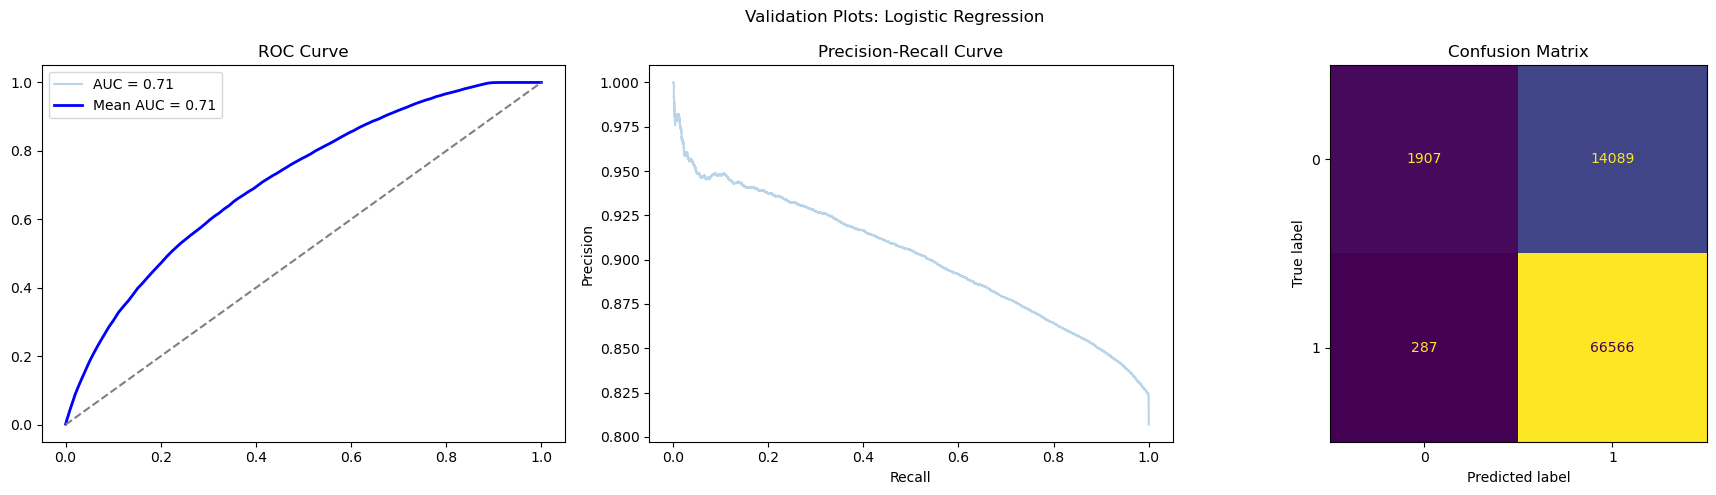

Naive Bayes:
RMSE: 0.5708
MAE: 0.3258
Accuracy: 0.6742
Precision: 0.8704
Recall: 0.7006
F1 Score: 0.7763
Cohen's Kappa: 0.2019
ROC AUC: 0.6323


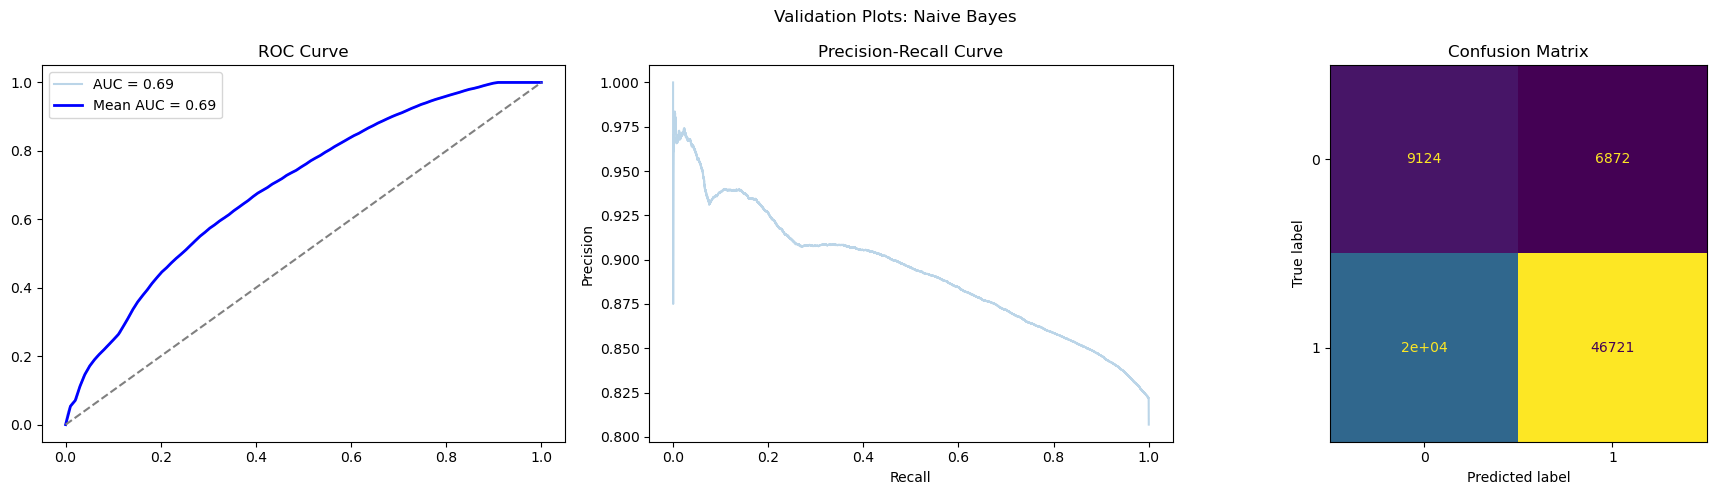

Complement Naive Bayes:
RMSE: 0.6511
MAE: 0.4240
Accuracy: 0.5760
Precision: 0.8441
Recall: 0.5821
F1 Score: 0.6891
Cohen's Kappa: 0.0889
ROC AUC: 0.5664


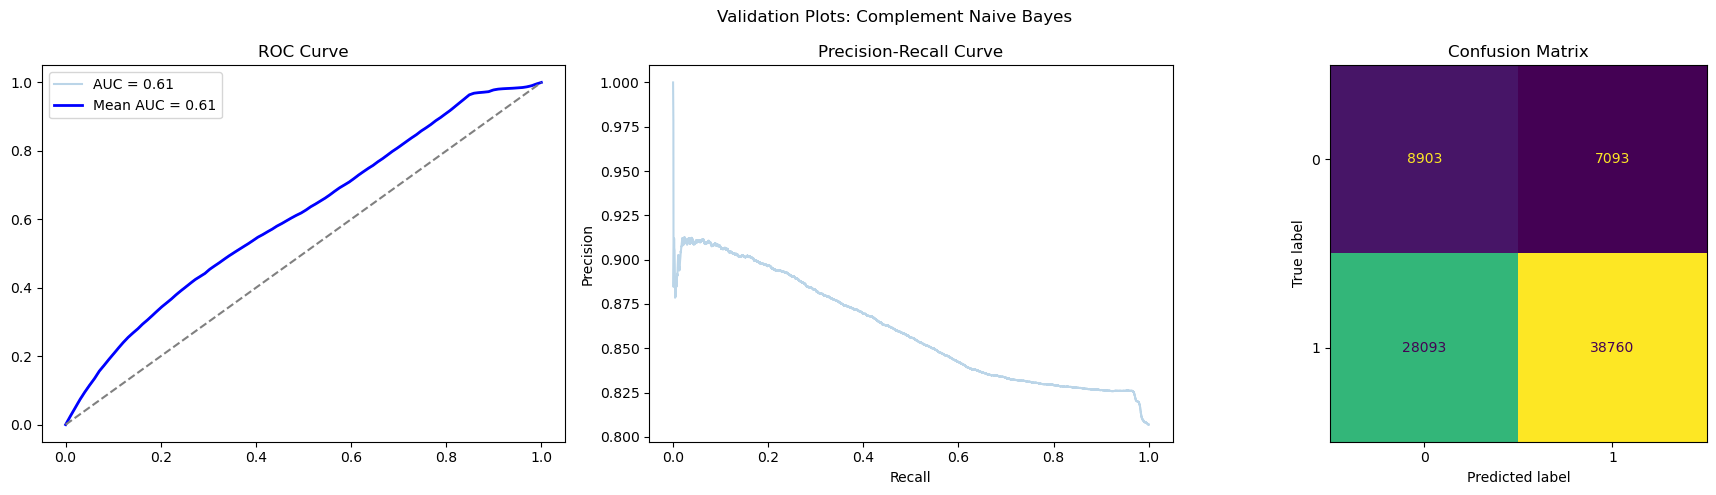

Random Forest:
RMSE: 0.2130
MAE: 0.0454
Accuracy: 0.9546
Precision: 0.9495
Recall: 0.9968
F1 Score: 0.9726
Cohen's Kappa: 0.8419
ROC AUC: 0.8876


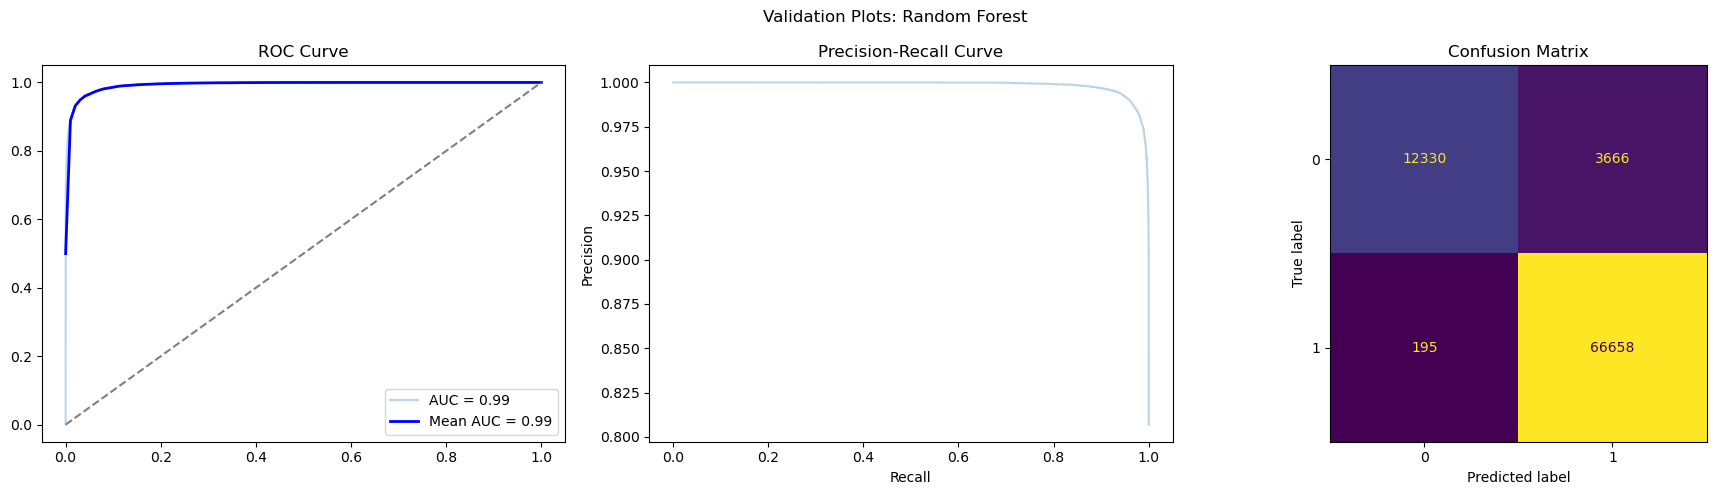

XGBoost:
RMSE: 0.2847
MAE: 0.0811
Accuracy: 0.9189
Precision: 0.9232
Recall: 0.9812
F1 Score: 0.9513
Cohen's Kappa: 0.7109
ROC AUC: 0.8199


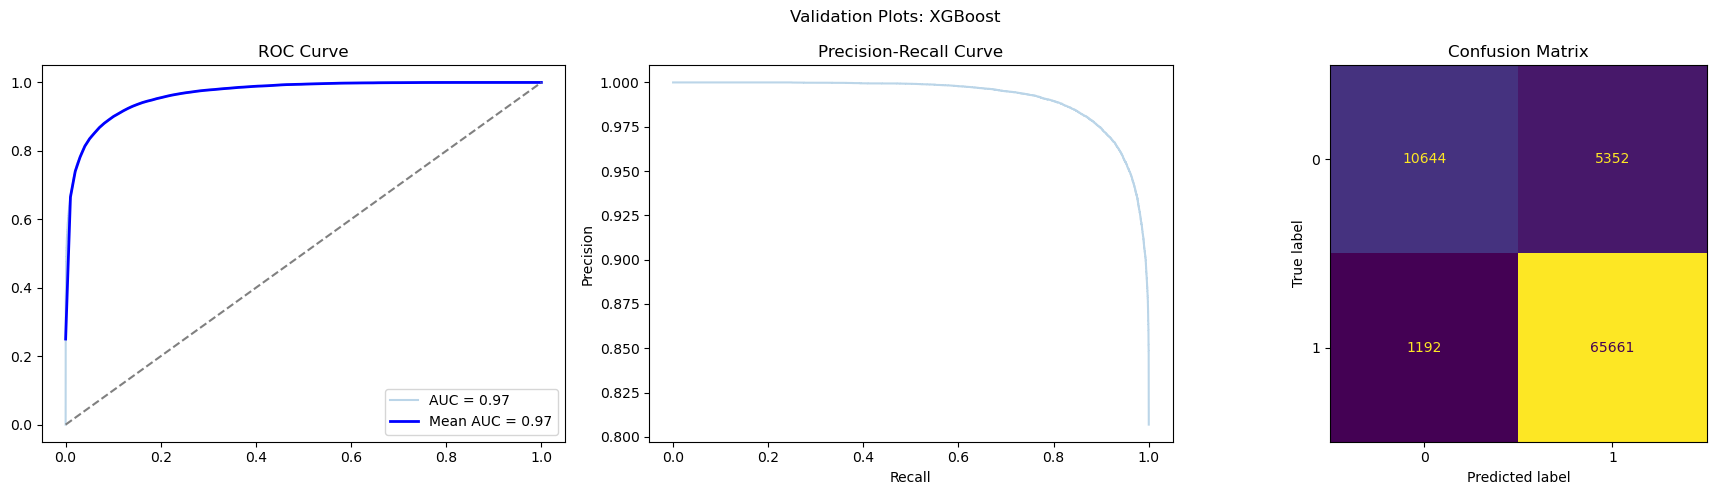

AdaBoost:
RMSE: 0.4126
MAE: 0.1702
Accuracy: 0.8298
Precision: 0.8277
Recall: 0.9965
F1 Score: 0.9043
Cohen's Kappa: 0.1916
ROC AUC: 0.5647


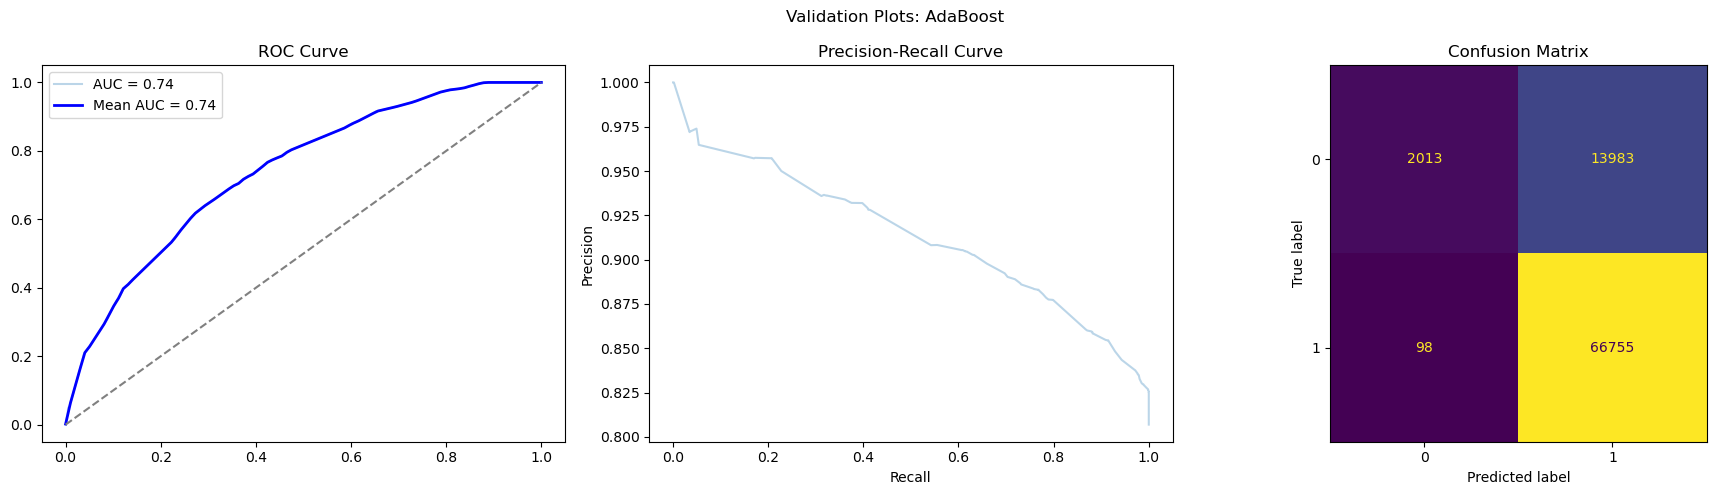

GradientBoost:
RMSE: 0.3956
MAE: 0.1565
Accuracy: 0.8435
Precision: 0.8436
Recall: 0.9896
F1 Score: 0.9108
Cohen's Kappa: 0.3072
ROC AUC: 0.6113


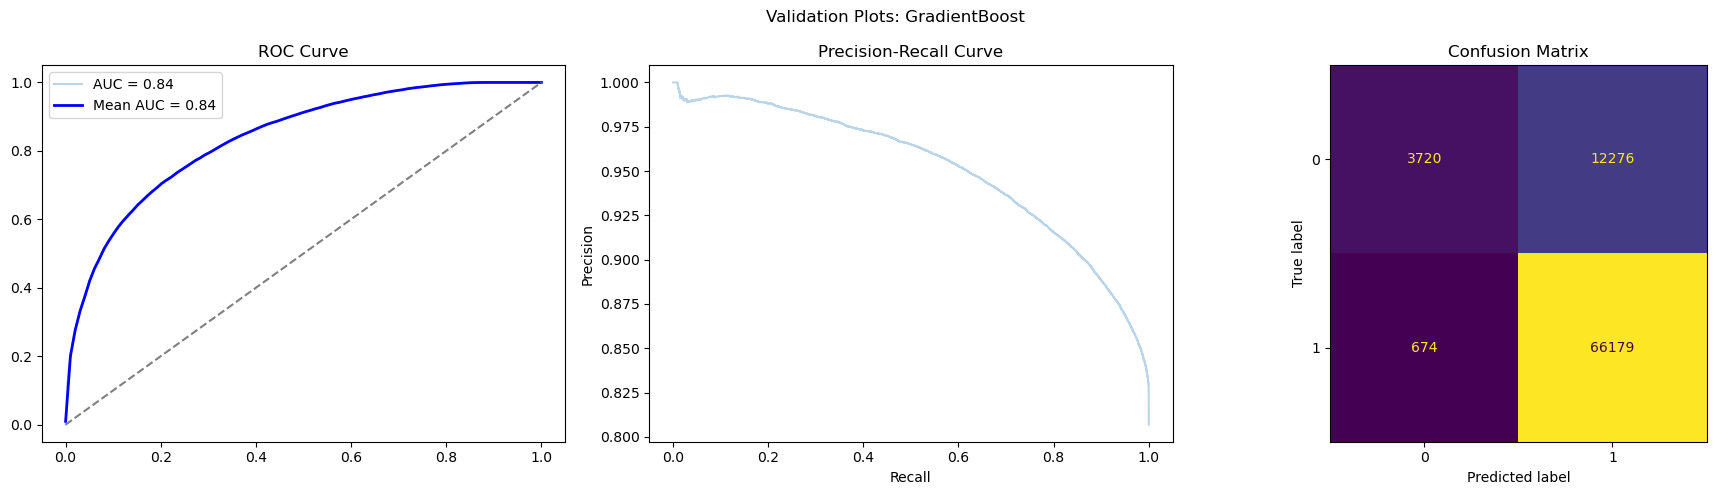

In [51]:
# Plots of classification results. Sadly we need to redo fitting, since cross_validate doesn't
# return everything we need
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc, precision_recall_curve, ConfusionMatrixDisplay

results_bin = {}
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=100)

for name, pipeline in pipelines_bin.items():
    print(f"{name}:")

    results_bin[name] = {"scores": {}, "y_true": [], "y_pred": [], "y_proba": []}

    fold_scores = {metric: [] for metric in val_metrics_bin}

    for train_idx, test_idx in kfold.split(X, y_bin):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y_bin.iloc[train_idx], y_bin.iloc[test_idx]

        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        y_proba = pipeline.predict_proba(X_test)[:,1]

        # Store for plotting
        results_bin[name]["y_true"].append(y_test)
        results_bin[name]["y_pred"].append(y_pred)
        results_bin[name]["y_proba"].append(y_proba)

        # Evaluate metrics
        for metric_name, scorer in val_metrics_bin.items():
            score_func = scorer._score_func
            needs_proba = scorer._kwargs.get("response_method") == "predict_proba"
            input_data = y_proba if needs_proba else y_pred
            score = score_func(y_test, input_data)
            fold_scores[metric_name].append(score)

    # Aggregate scores
    for metric_name, scores in fold_scores.items():
        avg_score = np.mean(scores)
        results_bin[name]["scores"][metric_name] = avg_score
        print(f"{metric_name}: {avg_score:.4f}")

    # Plotting
    fig, ax = plt.subplots(1, 3, figsize=(18, 5))
    all_tprs = []
    mean_fpr = np.linspace(0, 1, 100)

    for y_test, y_proba, y_pred in zip(results_bin[name]["y_true"],
                                       results_bin[name]["y_proba"],
                                       results_bin[name]["y_pred"]):
        # ROC
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        all_tprs.append(np.interp(mean_fpr, fpr, tpr))
        roc_auc = auc(fpr, tpr)
        ax[0].plot(fpr, tpr, alpha=0.3, label=f"AUC = {roc_auc:.2f}")

        # Precision-Recall
        precision, recall, _ = precision_recall_curve(y_test, y_proba)
        ax[1].plot(recall, precision, alpha=0.3)

        # Confusion matrix — show one for now
        ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax[2], colorbar=False)
        ax[2].set_title("Confusion Matrix")
        break  # Remove to show for every fold

    # Mean ROC
    mean_tpr = np.mean(all_tprs, axis=0)
    mean_auc = auc(mean_fpr, mean_tpr)
    ax[0].plot(mean_fpr, mean_tpr, color="b", label=f"Mean AUC = {mean_auc:.2f}", lw=2)
    ax[0].plot([0, 1], [0, 1], linestyle="--", color="gray")
    ax[0].set_title("ROC Curve")
    ax[0].legend()

    ax[1].set_title("Precision-Recall Curve")
    ax[1].set_xlabel("Recall")
    ax[1].set_ylabel("Precision")

    plt.suptitle(f"Validation Plots: {name}")
    plt.tight_layout()
    plt.show()


In [33]:
# Validation metrics on test set

for name, pipeline_bin in pipelines_bin.items():
    print(f"{name} (Test set):")
    pipeline_bin.fit(X_train_bin, y_train_bin)
    y_pred = pipeline_bin.predict(X_test)

    for metric_name, scorer in val_metrics_bin.items():
        test_score = scorer(pipeline_bin, X_test_bin, y_test_bin)
        print(f"{metric_name}: {test_score:.4f}")
    
    print()


Logistic Regression (Test set):


c:\Users\jorda\anaconda3\envs\introml\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


RMSE: 0.4178
MAE: 0.1746
Accuracy: 0.8254
Precision: 0.8253
Recall: 0.9941
F1 Score: 0.9019
Cohen's Kappa: 0.1689
ROC AUC: 0.7120

Naive Bayes (Test set):
RMSE: 0.5712
MAE: 0.3263
Accuracy: 0.6737
Precision: 0.8709
Recall: 0.6993
F1 Score: 0.7758
Cohen's Kappa: 0.2024
ROC AUC: 0.6945

Complement Naive Bayes (Test set):
RMSE: 0.6495
MAE: 0.4219
Accuracy: 0.5781
Precision: 0.8452
Recall: 0.5843
F1 Score: 0.6909
Cohen's Kappa: 0.0916
ROC AUC: 0.6087

Random Forest (Test set):
RMSE: 0.2190
MAE: 0.0480
Accuracy: 0.9520
Precision: 0.9466
Recall: 0.9967
F1 Score: 0.9710
Cohen's Kappa: 0.8318
ROC AUC: 0.9933

XGBoost (Test set):
RMSE: 0.2793
MAE: 0.0780
Accuracy: 0.9220
Precision: 0.9258
Recall: 0.9820
F1 Score: 0.9531
Cohen's Kappa: 0.7227
ROC AUC: 0.9668

XGBoost Tuned (Test set):
RMSE: 0.4089
MAE: 0.1672
Accuracy: 0.8328
Precision: 0.8298
Recall: 0.9975
F1 Score: 0.9059
Cohen's Kappa: 0.2087
ROC AUC: 0.7972

AdaBoost (Test set):
RMSE: 0.4129
MAE: 0.1705
Accuracy: 0.8295
Precision: 0.8278
Re

In [34]:
# Validation metrics on temporal test set

for name, pipeline_bin in pipelines_bin.items():
    print(f"{name} (Temporal test set):")
    pipeline_bin.fit(X_train_time, y_train_bin_time)
    #y_pred = pipeline_bin.predict(X_test_time)

    for metric_name, scorer in val_metrics_bin.items():
        test_score = scorer(pipeline_bin, X_test_time, y_test_bin_time)
        print(f"{metric_name}: {test_score:.4f}")
    
    print()


Logistic Regression (Temporal test set):


c:\Users\jorda\anaconda3\envs\introml\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


RMSE: 0.4617
MAE: 0.2132
Accuracy: 0.7868
Precision: 0.7874
Recall: 0.9987
F1 Score: 0.8806
Cohen's Kappa: 0.0051
ROC AUC: 0.4163

Naive Bayes (Temporal test set):
RMSE: 0.5140
MAE: 0.2642
Accuracy: 0.7358
Precision: 0.7841
Recall: 0.9167
F1 Score: 0.8452
Cohen's Kappa: -0.0198
ROC AUC: 0.6392

Complement Naive Bayes (Temporal test set):
RMSE: 0.5519
MAE: 0.3046
Accuracy: 0.6954
Precision: 0.8775
Recall: 0.7124
F1 Score: 0.7864
Cohen's Kappa: 0.2754
ROC AUC: 0.6862

Random Forest (Temporal test set):
RMSE: 0.4721
MAE: 0.2228
Accuracy: 0.7772
Precision: 0.7917
Recall: 0.9728
F1 Score: 0.8729
Cohen's Kappa: 0.0401
ROC AUC: 0.6681

XGBoost (Temporal test set):
RMSE: 0.4784
MAE: 0.2289
Accuracy: 0.7711
Precision: 0.7940
Recall: 0.9575
F1 Score: 0.8681
Cohen's Kappa: 0.0562
ROC AUC: 0.5736

XGBoost Tuned (Temporal test set):
RMSE: 0.4616
MAE: 0.2130
Accuracy: 0.7870
Precision: 0.7870
Recall: 0.9999
F1 Score: 0.8808
Cohen's Kappa: 0.0011
ROC AUC: 0.5484

AdaBoost (Temporal test set):
RMSE: 0

In [55]:
# Exploration of feature importance of various models

def get_coeffients(pipeline, model_name):
    '''Get coefficients/p-values (proxy for feature importance) for the
    regression models'''
    pipeline.fit(X, y)
    coefficients = pipeline.named_steps[model_name].coef_
    feature_names = ct.get_feature_names_out()
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coefficients
    }).sort_values(by='Coefficient', key=abs, ascending=False)
    return importance_df

linear_importance = get_coeffients(pipelines['Linear Regression'], 'linearregression')
#ridge_importance = get_coeffients(pipelines['Ridge Regression'], 'ridge')
lasso_importance = get_coeffients(pipelines['Lasso Regression'], 'lasso')

print("Linear Regression:")
print(linear_importance)

#print("\nRidge Regression:")
#print(ridge_importance)

print("\nLasso Regression:")
print(lasso_importance)



Linear Regression:
                                 Feature  Coefficient
12     onehotencoder__site_Lawrenceville    55.413598
40   onehotencoder__PM25_source_PM25_640   -36.842615
38      onehotencoder__PM25_source_PM25B    27.778907
37       onehotencoder__PM25_source_PM25    22.233580
14           onehotencoder__site_Lincoln   -19.493069
16      onehotencoder__site_Parkway East   -16.071313
39      onehotencoder__PM25_source_PM25T   -13.169872
13         onehotencoder__site_Liberty 2   -12.165671
41                       remainder__year     9.098857
15    onehotencoder__site_North Braddock    -8.147941
22            onehotencoder__season_Fall     7.790197
23          onehotencoder__season_Spring    -6.395907
24          onehotencoder__season_Summer    -6.261675
25          onehotencoder__season_Winter     4.867384
20    onehotencoder__time_of_day_Morning     4.199633
3                 simpleimputer__SONICWS    -3.649395
11          onehotencoder__site_Clairton    -3.033976
4        

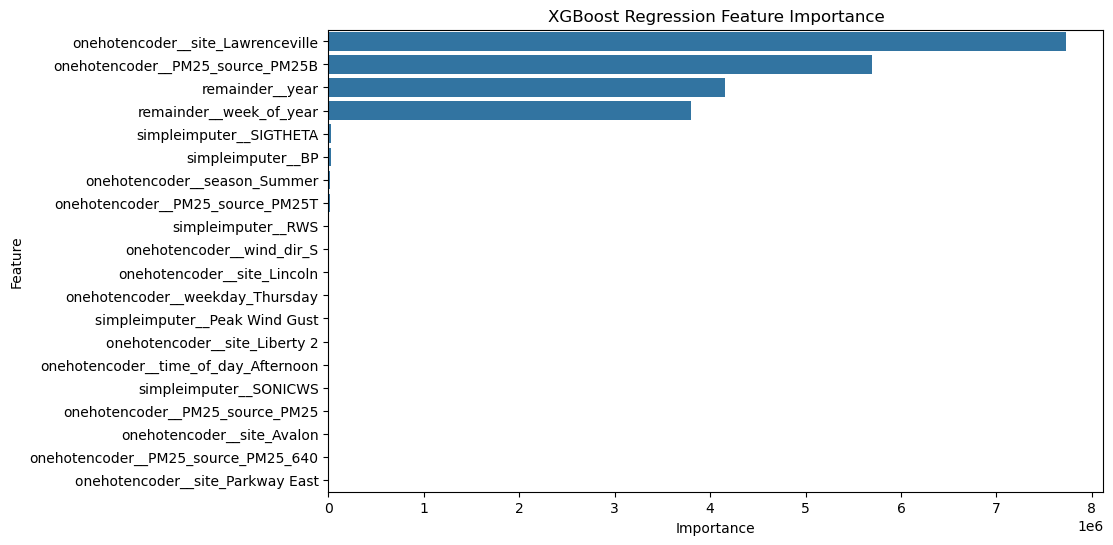

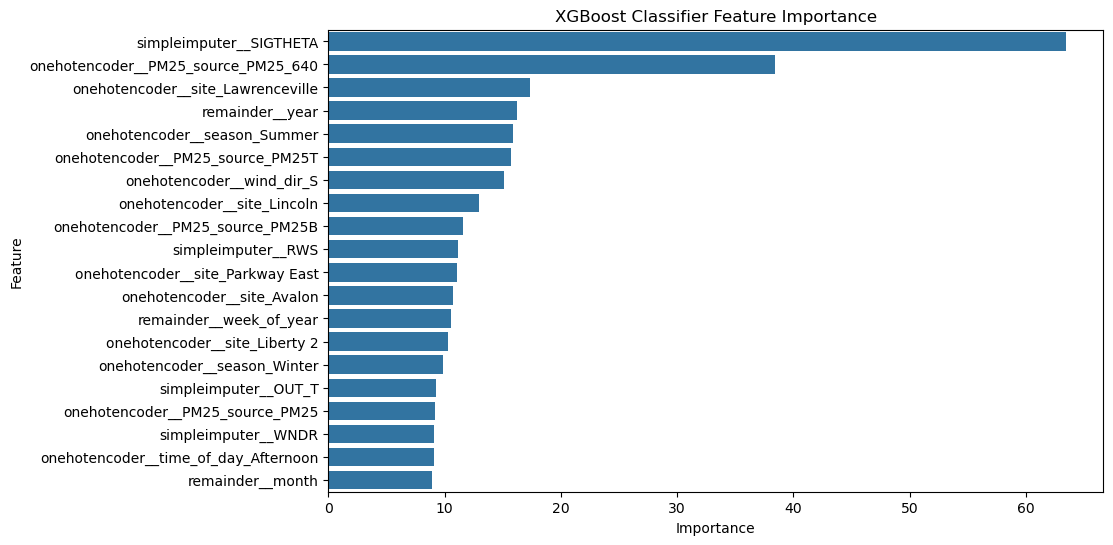

In [57]:
# Feature importance for XGBoost. We need to retrain, since results aren't available from xval above.
from sklearn.model_selection import cross_validate

xgb_cv = cross_validate(pipelines['XGBoost'], X, y, cv=5, return_estimator=True,
    #scoring='neg_root_mean_squared_error'
)
xgb_feats = xgb_cv['estimator'][0].named_steps['columntransformer'].get_feature_names_out()
xgb_importance = np.zeros((len(xgb_cv['estimator']), len(xgb_feats)))

# We average importance across folds
for i, model in enumerate(xgb_cv['estimator']):
    booster = model.named_steps['xgbregressor'].get_booster()
    importances = booster.get_score(importance_type='gain')
    
    for j in range(len(xgb_feats)):
        xgb_importance[i, j] = importances.get(f'f{j}', 0)

xgb_importance = pd.DataFrame({'Feature': xgb_feats, 'Importance': xgb_importance.mean(axis=0)
}).sort_values(by='Importance', ascending=False)
xgb_importance

plt.figure(figsize=(10, 6))
plt.title('XGBoost Regression Feature Importance')
sns.barplot(data=xgb_importance.head(20), x='Importance', y='Feature')
plt.show()

# And the classification version
xgb_cv_bin = cross_validate(pipelines['XGBoost'], X, y_bin, cv=5, return_estimator=True,
    #scoring='neg_root_mean_squared_error'
)
xgb_feats_bin = xgb_cv_bin['estimator'][0].named_steps['columntransformer'].get_feature_names_out()
xgb_importance_bin = np.zeros((len(xgb_cv_bin['estimator']), len(xgb_feats_bin)))

# We average importance across folds
for i, model in enumerate(xgb_cv_bin['estimator']):
    booster = model.named_steps['xgbregressor'].get_booster()
    importances = booster.get_score(importance_type='gain')
    
    for j in range(len(xgb_feats_bin)):
        xgb_importance_bin[i, j] = importances.get(f'f{j}', 0)

xgb_importance_bin = pd.DataFrame({'Feature': xgb_feats_bin, 'Importance': xgb_importance_bin.mean(axis=0)
}).sort_values(by='Importance', ascending=False)
xgb_importance_bin

plt.figure(figsize=(10, 6))
sns.barplot(data=xgb_importance_bin.head(20), x='Importance', y='Feature')
plt.title('XGBoost Classifier Feature Importance')
plt.show()

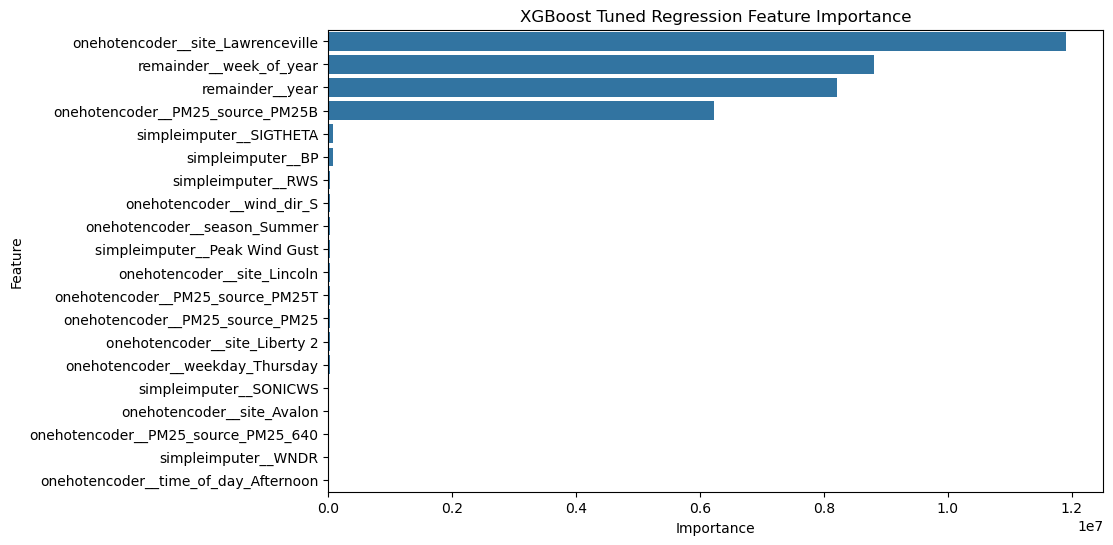

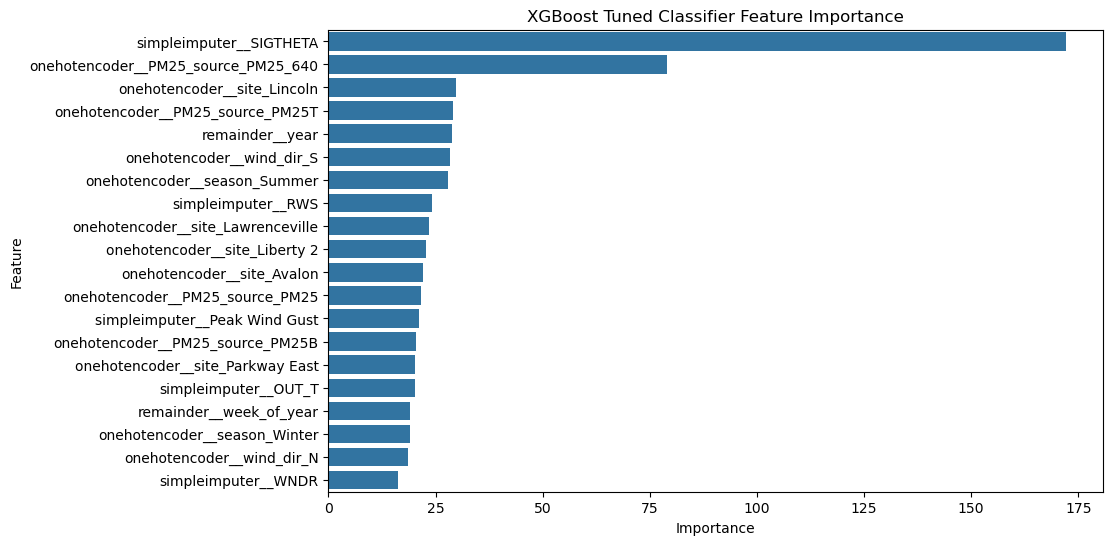

In [39]:
# Feature importance for the tuned XGBoost models

xgb_cv = cross_validate(pipelines['XGBoost Tuned'], X, y, cv=5, return_estimator=True,
    #scoring='neg_root_mean_squared_error'
)
xgb_feats = xgb_cv['estimator'][0].named_steps['columntransformer'].get_feature_names_out()
xgb_importance = np.zeros((len(xgb_cv['estimator']), len(xgb_feats)))

# We average importance across folds
for i, model in enumerate(xgb_cv['estimator']):
    booster = model.named_steps['xgbregressor'].get_booster()
    importances = booster.get_score(importance_type='gain')
    
    for j in range(len(xgb_feats)):
        xgb_importance[i, j] = importances.get(f'f{j}', 0)

xgb_importance = pd.DataFrame({'Feature': xgb_feats, 'Importance': xgb_importance.mean(axis=0)
}).sort_values(by='Importance', ascending=False)
xgb_importance

plt.figure(figsize=(10, 6))
plt.title('XGBoost Tuned Regression Feature Importance')
sns.barplot(data=xgb_importance.head(20), x='Importance', y='Feature')
plt.show()

# And the classification version
xgb_cv_bin = cross_validate(pipelines['XGBoost Tuned'], X, y_bin, cv=5, return_estimator=True,
    #scoring='neg_root_mean_squared_error'
)
xgb_feats_bin = xgb_cv_bin['estimator'][0].named_steps['columntransformer'].get_feature_names_out()
xgb_importance_bin = np.zeros((len(xgb_cv_bin['estimator']), len(xgb_feats_bin)))

# We average importance across folds
for i, model in enumerate(xgb_cv_bin['estimator']):
    booster = model.named_steps['xgbregressor'].get_booster()
    importances = booster.get_score(importance_type='gain')
    
    for j in range(len(xgb_feats_bin)):
        xgb_importance_bin[i, j] = importances.get(f'f{j}', 0)

xgb_importance_bin = pd.DataFrame({'Feature': xgb_feats_bin, 'Importance': xgb_importance_bin.mean(axis=0)
}).sort_values(by='Importance', ascending=False)
xgb_importance_bin

plt.figure(figsize=(10, 6))
sns.barplot(data=xgb_importance_bin.head(20), x='Importance', y='Feature')
plt.title('XGBoost Tuned Classifier Feature Importance')
plt.show()

In [58]:
# Sklearn doesn't give us p-values, which would be useful to know for the simple linear model
import statsmodels.api as sm

# Preprocess X again, since we can't use pipelines outside sklearn
X_transformed = ct.fit_transform(X)

# Convert pack to df to keep colnames
X_transformed = pd.DataFrame(X_transformed, columns=ct.get_feature_names_out(input_features=X.columns))
X_transformed = sm.add_constant(X_transformed)

# Annoying type conversion for indexes, since sm is finicky
y.index = pd.RangeIndex(start=0, stop=len(y), step=1)

lin_mod = sm.OLS(y, X_transformed.astype(float)).fit()
print(lin_mod.summary())

                            OLS Regression Results                            
Dep. Variable:         PM25_coalesced   R-squared:                       0.146
Model:                            OLS   Adj. R-squared:                  0.146
Method:                 Least Squares   F-statistic:                     1725.
Date:                Sun, 27 Apr 2025   Prob (F-statistic):               0.00
Time:                        21:06:59   Log-Likelihood:            -2.3654e+06
No. Observations:              414243   AIC:                         4.731e+06
Df Residuals:                  414201   BIC:                         4.731e+06
Df Model:                          41                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


In [ ]:
# Average error by sensor site
from sklearn.model_selection import cross_val_predict

error_by_site = pd.DataFrame()

# First, for the regression models. We need to crossval again to get residuals, using
# whole dataset this time
for name, pipeline in pipelines.items():
    print(f'Building site metrics for: {name}')
    y_pred_regr = cross_val_predict(pipeline, X, y, cv=5)

    site_errors = X.copy()
    site_errors['y'] = y
    site_errors['residual'] = y - y_pred_regr
    site_errors['abs_error'] = np.abs(site_errors['residual'])
    site_errors['sq_error'] = (site_errors['residual']) ** 2

    # Compute aggregate metrics over site
    this_site = site_errors.groupby('site').agg(
        N=('y', 'size'),
        MAE=('abs_error', 'mean'),
        ME=('residual', 'mean'),
        RMSE=('sq_error', lambda x: np.sqrt(x.mean()))
    ).reset_index()

    this_site['model'] = name
    error_by_site = pd.concat([error_by_site, this_site], ignore_index=True)



In [41]:
# cut things down, to make it easier to dev
#X_sub = X.sample(frac=.05, random_state=5)
#y_sub = y_bin.loc[X_sub.index]  

# The same site-based metric creation, for the classification models
error_by_site_bin = pd.DataFrame()

def class_val_metrics(df):
    '''Compute classification validation metrics, for applying to groups'''
    N = df.shape[0]
    accuracy = accuracy_score(df['y'], df['y_pred'])
    precision = precision_score(df['y'], df['y_pred'], zero_division=0)
    recall = recall_score(df['y'], df['y_pred'], zero_division=0)
    f1 = f1_score(df['y'], df['y_pred'], zero_division=0)
    # Need to handle 'Lawrenceville 2' site
    if df['y_pred_prob'].nunique() > 1 and df['y'].nunique() > 1:
        auc = roc_auc_score(df['y'], df['y_pred_prob'])
    else:
        auc = np.nan
    
    return pd.Series({'N': N, 'Accuracy': accuracy, 'Precision': precision,
                      'Recall': recall, 'F1': f1, 'AUC': auc})


for name, pipeline in pipelines_bin.items():
    print(f'Building site metrics for: {name}')
    # We use proba (on the 1/true class) for our error metrics
    y_pred_bin = cross_val_predict(pipeline, X, y_bin, cv=5, method='predict')
    y_pred_bin_prob = cross_val_predict(pipeline, X, y_bin, cv=5, method='predict_proba')[:,1]

    site_errors = X.copy()
    site_errors['y'] = y_bin
    site_errors['y_pred'] = y_pred_bin
    site_errors['y_pred_prob'] = y_pred_bin_prob

    # Compute aggregate metrics over site
    this_site_bin = site_errors.groupby('site').apply(class_val_metrics).reset_index()

    this_site_bin['model'] = name
    error_by_site_bin = pd.concat([error_by_site_bin, this_site_bin], ignore_index=True)


Building site metrics for: Logistic Regression


c:\Users\jorda\anaconda3\envs\introml\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\jorda\anaconda3\envs\introml\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Building site metrics for: Naive Bayes


C:\Users\jorda\AppData\Local\Temp\ipykernel_48552\749124860.py:37: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  this_site_bin = site_errors.groupby('site').apply(class_val_metrics).reset_index()


Building site metrics for: Complement Naive Bayes


C:\Users\jorda\AppData\Local\Temp\ipykernel_48552\749124860.py:37: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  this_site_bin = site_errors.groupby('site').apply(class_val_metrics).reset_index()


Building site metrics for: Random Forest


C:\Users\jorda\AppData\Local\Temp\ipykernel_48552\749124860.py:37: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  this_site_bin = site_errors.groupby('site').apply(class_val_metrics).reset_index()


Building site metrics for: XGBoost


C:\Users\jorda\AppData\Local\Temp\ipykernel_48552\749124860.py:37: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  this_site_bin = site_errors.groupby('site').apply(class_val_metrics).reset_index()


Building site metrics for: XGBoost Tuned


C:\Users\jorda\AppData\Local\Temp\ipykernel_48552\749124860.py:37: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  this_site_bin = site_errors.groupby('site').apply(class_val_metrics).reset_index()


Building site metrics for: AdaBoost


C:\Users\jorda\AppData\Local\Temp\ipykernel_48552\749124860.py:37: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  this_site_bin = site_errors.groupby('site').apply(class_val_metrics).reset_index()


Building site metrics for: GradientBoost


KeyboardInterrupt: 

In [42]:
error_by_site.to_csv('../../error_by_site.csv')
error_by_site_bin.to_csv('../../error_by_site_bin.csv')